# Library

In [2]:
import numpy as np
import torch
import torch.nn as nn

import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Working on device {device}")

Working on device cpu


# Load dataset

In [3]:
# Transform image to 1x784 and normalize colors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download dataset
trainset = datasets.MNIST('dataset', download=False, train=True, transform=transform)
valset = datasets.MNIST('dataset', download=False, train=False, transform=transform)

# Create dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=3000, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=3000, shuffle=True)

# for idx, (data, target) in enumerate(trainloader):
#     data = data.to(device)
#     target = target.to(device)

# for idx, (data, target) in enumerate(valloader):
#     data = data.to(device)
#     target = target.to(device)    

# Preliminary computation

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]])


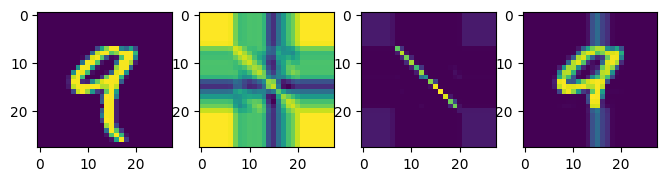

In [30]:
img, label = trainset[4]
input_size = img.shape[1:]

Q = img.clone()
K = img.clone()
V = img.clone()

soft_max = nn.Softmax(dim=2)

QT = torch.transpose(Q, 1, 2)

qTk = torch.bmm(QT, K)
atten_weight = soft_max(qTk)

Att_pool = torch.bmm(atten_weight, V)

fig, ax = plt.subplots(figsize=(8,2), nrows=1, ncols=4)
plt.subplot(1,4,1)
plt.imshow(Q.squeeze(0))
plt.subplot(1,4,2)
plt.imshow(qTk.squeeze(0))
plt.subplot(1,4,3)
plt.imshow(atten_weight.squeeze(0))

plt.subplot(1,4,4)
plt.imshow(Att_pool.squeeze(0))
Att_pool = Att_pool.squeeze(0)
print(atten_weight.sum(dim=2))

# Model description

$$ \mathrm{Attention}(\mathbf{q},\mathbf{k},\mathbf{v}) = \sum_{i=1}^m{\alpha(\mathbf{q},\mathbf{k}_i) \mathbf{v}_i} $$

where $\mathbf{q}, \mathbf{k}, \mathbf{v} \in \mathbb{R}^d$.

Scaled dot product attention scoring function:

$$ a(\mathbf{q},\mathbf{k}_i) = \mathbf{q}^T \mathbf{k}_i / \sqrt{d} $$

Attention weights

$$ \alpha(\mathbf{q},\mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q},\mathbf{k}_i)) = \frac{\exp(\mathbf{q}^T \mathbf{k}_i / \sqrt{d})}{\sum_{j=1}\exp(\mathbf{q}^T \mathbf{k}_j / \sqrt{d})}$$

In [4]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    # def __init__(self, dropout):
    def __init__(self):
        super().__init__()
        # self.dropout = nn.Dropout(dropout)
        self.soft_max = nn.Softmax(dim=2)
        

    # Shape of queries: (batch_size, img-height, d)
    # Shape of keys: (batch_size, img-height, d)
    # Shape of values: (batch_size, img-height, value dimension)
    def forward(self, queries, keys, values):
        d = queries.shape[2]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / np.sqrt(d)
        self.attention_weights = self.soft_max(scores)
        # return torch.bmm(self.dropout(self.attention_weights), values)
        return torch.bmm(self.attention_weights, values)

class sa_NN(nn.Module):
    def __init__(self, input_size, num_classes, device='cpu'):
        super(sa_NN, self).__init__()
        d_model = input_size
        self.W_q = nn.Linear(input_size, d_model, device=device)
        self.W_k = nn.Linear(input_size, d_model, device=device)
        self.W_v = nn.Linear(input_size, d_model, device=device)
        self.W_o = nn.Linear(input_size*input_size, num_classes, device=device)
        
        self.num_classes = num_classes
        
        self.SDPA = DotProductAttention()

        self.log_softmax = nn.LogSoftmax(dim=1)

        nn.init.xavier_uniform_(self.W_q.weight)
        nn.init.xavier_uniform_(self.W_k.weight)
        nn.init.xavier_uniform_(self.W_v.weight)
        nn.init.xavier_uniform_(self.W_o.weight)

    def forward(self, x):
        # Multiply input by weights and add biases
        
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        
        out = self.SDPA(Q, K, V)
        out = out.reshape(out.shape[0],-1)
        # out = nn.functional.softmax(self.W_o(out),dim=0)
        out = self.log_softmax(self.W_o(out))
        
        return out

# Train loop

In [ ]:
# Build the Neural Network
input_size = 28  # 28x28 images flattened
output_size = 10  # 10 classes for digits 0-9

model = sa_NN(input_size,output_size, device=device)
model.load_state_dict(torch.load('model_backup\sa_NN_epoch_200.pth', map_location=torch.device('cpu')))
# model = torch.load('model_backup\sa_NN_epoch_100.pth')
# print(model)
model.to(device)

# criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss which includes softmax
criterion = nn.NLLLoss()  # Use CrossEntropyLoss which includes softmax
# optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Track loss
loss_list = []

# Training the network
epochs = 300
time0 = time()

for epoch in range(epochs):
    running_loss = 0

    for images, labels in tqdm(trainloader, leave=False):
    # for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)

        images = images.squeeze(1)                 
        
        labels.to(device)

        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)               
        
        # This is where the model learns by back propagating
        loss.backward()
        
        # And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()

    
    CE_curr = running_loss / len(trainloader)
    loss_list.append(CE_curr)
    if (epoch%5)==0:
        print(f"Epoch {epoch} - Training loss: {CE_curr:.5f}")
    
print(f"\nTraining Time (in minutes) = {(time()-time0)/60}")

# Convert lists to numpy arrays
loss_array = np.array(loss_list)

# Save arrays to .npy files
np.save('loss_values.npy', loss_array)

# Save the model
torch.save(model.state_dict(), f'model_backup\sa_NN_epoch_{epochs}.pth')


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 - Training loss: 0.27339


Epoch 6 - Training loss: 0.27103


Epoch 11 - Training loss: 0.27019


Epoch 16 - Training loss: 0.26971


Epoch 21 - Training loss: 0.26840


Epoch 26 - Training loss: 0.26795


Epoch 31 - Training loss: 0.26680


Epoch 36 - Training loss: 0.26612


Epoch 41 - Training loss: 0.26535


Epoch 46 - Training loss: 0.26428


Epoch 51 - Training loss: 0.26385


Epoch 56 - Training loss: 0.26276


Epoch 61 - Training loss: 0.26188


Epoch 66 - Training loss: 0.26138


Epoch 71 - Training loss: 0.26088


Epoch 76 - Training loss: 0.26028


Epoch 81 - Training loss: 0.25905


Epoch 86 - Training loss: 0.25873


Epoch 91 - Training loss: 0.25838


Epoch 96 - Training loss: 0.25758


Epoch 101 - Training loss: 0.25677


Epoch 106 - Training loss: 0.25643


Epoch 111 - Training loss: 0.25575


Epoch 116 - Training loss: 0.25530


Epoch 121 - Training loss: 0.25463


Epoch 126 - Training loss: 0.25408


Epoch 131 - Training loss: 0.25350


Epoch 136 - Training loss: 0.25323


Epoch 141 - Training loss: 0.25266


Epoch 146 - Training loss: 0.25192


Epoch 151 - Training loss: 0.25173


Epoch 156 - Training loss: 0.25110


Epoch 161 - Training loss: 0.25073


Epoch 166 - Training loss: 0.25065


Epoch 171 - Training loss: 0.25000


Epoch 176 - Training loss: 0.24936


Epoch 181 - Training loss: 0.24913


Epoch 186 - Training loss: 0.24882


Epoch 191 - Training loss: 0.24838


Epoch 196 - Training loss: 0.24768


Epoch 201 - Training loss: 0.24714


Epoch 206 - Training loss: 0.24703


Epoch 211 - Training loss: 0.24671


Epoch 216 - Training loss: 0.24596


Epoch 221 - Training loss: 0.24580


Epoch 226 - Training loss: 0.24545


Epoch 231 - Training loss: 0.24521


Epoch 236 - Training loss: 0.24514


Epoch 241 - Training loss: 0.24459


Epoch 246 - Training loss: 0.24405


Epoch 251 - Training loss: 0.24377


Epoch 256 - Training loss: 0.24392


Epoch 261 - Training loss: 0.24325


Epoch 266 - Training loss: 0.24301


Epoch 271 - Training loss: 0.24290


Epoch 276 - Training loss: 0.24198


Epoch 281 - Training loss: 0.24227


Epoch 286 - Training loss: 0.24159


Epoch 291 - Training loss: 0.24129


Epoch 296 - Training loss: 0.24119



Training Time (in minutes) = 130.21014488140742


NameError: name 'mse_list' is not defined

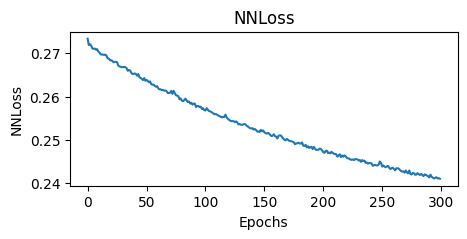

In [17]:
# Save arrays to .npy files
np.save('loss_values.npy', loss_array)

# Save the model
torch.save(model.state_dict(), f'model_backup\sa_NN_epoch_{epochs}.pth')

# Plot CE
plt.figure(figsize=(5, 2))
plt.plot(range(len(loss_array)), loss_array, label='NNLoss')
plt.xlabel('Epochs')
plt.ylabel('NNLoss')
plt.title('NNLoss')
# plt.legend()
plt.show()

# NN test

In [18]:
input_size = 28  # 28x28 images flattened
output_size = 10  # 10 classes for digits 0-9

model = sa_NN(input_size,output_size, device=device)
model.load_state_dict(torch.load('model_backup\sa_NN_epoch_300.pth', map_location=torch.device('cpu')))
model.to(device)

correct = 0
total = 0

model.eval()
for X, y_true in valloader:
    X = X.squeeze(1) 
    
    outputs = model(X)
    _,y_pred = torch.max(outputs, dim=1)
    total +=y_true.shape[0]
    correct +=int((y_pred==y_true).sum())

print(f"Accuracy = {correct/total: .3f}")

Accuracy =  0.918
